In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-08 04:44:31,008 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
            yt = np.array(y.loc[:, col], dtype=float)
            yp = np.array(y_pred.loc[:, col], dtype=float)

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
                ss_tot = spst.circvar(yt, low=-np.pi / 2, high=np.pi / 2)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
#             'best_params': best_params,
            'best_cost': best_cost,# if 'best_score' not in specifics else specifics['best_score'],
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
#         row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shape3fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 107 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,False,5.498457,9965.799766,12-005_C__shape3fit-swarm_2018-04-07_08-48-23....,../../results/shape3fit,C,19,0.093140,-0.075367,-1.622581,0.106350,12-005
1,True,6.125872,9417.414645,12-005_C_adjust_shape3fit-swarm_2018-04-06_03-...,../../results/shape3fit,C,18,-1.061929,-0.651692,-0.766857,0.354606,12-005
2,True,5.859562,8711.233511,12-005_C_adjust_shape3fit-swarm_2018-04-06_06-...,../../results/shape3fit,C,18,-0.002360,-0.889408,-1.405388,0.437595,12-005
3,True,6.136616,3859.541214,12-005_C_adjust_shape3fit-swarm_2018-04-06_08-...,../../results/shape3fit,C,18,-0.477584,-0.649230,-1.352644,0.342843,12-005
4,True,5.186785,11402.948989,12-005_C_adjust_shape3fit-swarm_2018-04-06_09-...,../../results/shape3fit,C,18,0.213425,-0.816078,-1.037671,0.453539,12-005
5,True,5.632257,5977.974850,12-005_C_adjust_shape3fit-swarm_2018-04-06_13-...,../../results/shape3fit,C,18,-0.190389,-0.679440,-1.074432,0.312003,12-005
6,False,5.915450,13778.072687,12-005_D__shape3fit-swarm_2018-04-07_06-46-21....,../../results/shape3fit,D,19,-1.156467,-0.490968,-0.848477,0.580463,12-005
7,False,5.958927,7095.789336,12-005_D__shape3fit-swarm_2018-04-07_10-36-01....,../../results/shape3fit,D,19,-0.687237,-0.176290,-1.563584,0.468184,12-005
8,False,5.949070,14521.227399,12-005_D__shape3fit-swarm_2018-04-07_12-34-19....,../../results/shape3fit,D,19,-0.285511,-0.495621,-1.478287,0.310350,12-005
9,True,5.679829,4969.764468,12-005_D_adjust_shape3fit-swarm_2018-04-06_03-...,../../results/shape3fit,D,18,0.123552,-0.882445,-1.127949,0.207013,12-005


In [6]:
data.n_samples.unique()

array([19, 18, 15, 14, 13, 17, 10,  9, 11])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime'].agg(['mean', 'count'])

mean  count
subject model adjust_bias                     
12-005  C     False         9965.799766      1
              True          7873.822642      5
        D     False        11798.363141      3
              True          8408.953753      6
51-009  C     False        14881.309805      4
              True         19739.121119     10
        D     False        17884.084711      8
              True         26610.499948     13
52-001  A     False          232.805087      3
        B     True           228.629092      3
        C     False         9012.878391      4
              True         12573.143094      6
        D     False         8919.251442      3
              True          9612.614561      6
TB      A     False           74.943614      5
              True            96.685224      3
        B     False          136.681368      3
        C     False        13583.270072      7
              True         12614.529351      5
        D     False        13566.914125      3
              True         14577.969700      6

# The best runs in their respective category

In [9]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols).max()

Best scores:


best_cost   r2_area  r2_compactness  \
subject model adjust_bias                                         
12-005  C     False          5.498457  0.093140       -0.075367   
              True           5.186785  0.213425       -0.816078   
        D     False          5.915450 -1.156467       -0.490968   
              True           4.497768  0.108935       -0.699854   
51-009  C     False          6.153776 -0.573670       -1.052110   
              True           5.045589 -0.540609       -0.536747   
        D     False          8.898483 -0.344985       -0.636227   
              True           7.007622 -0.960224       -0.617837   
52-001  A     False         10.450473 -3.864845       -0.736894   
        B     True           4.262802  0.279744       -0.414865   
        C     False          3.566731 -0.111110       -0.213016   
              True           3.454419 -0.008376       -0.097296   
        D     False          3.630214 -0.013295       -0.307011   
              True           4.028567 -0.182156       -0.137951   
TB      A     False         46.461373 -6.615204       -4.524287   
              True         187.298177 -9.369495       -4.595265   
        B     False         16.493910 -6.075608       -2.230291   
        C     False          4.101151 -0.375639       -0.129181   
              True           3.605952 -0.428410        0.072310   
        D     False          5.466909 -1.613568       -0.422618   
              True           5.185300 -1.577292        0.276654   

                           r2_eccentricity  r2_orientation  
subject model adjust_bias                                   
12-005  C     False              -1.622581        0.106350  
              True               -1.037671        0.453539  
        D     False              -0.848477        0.580463  
              True               -0.370990        0.464141  
51-009  C     False              -0.669544        0.141548  
              True                0.069386       -0.037619  
        D     False              -3.593293       -0.323978  
              True               -1.103872       -0.325688  
52-001  A     False              -2.437182        0.588449  
        B     True               -0.578666        0.450985  
        C     False               0.193169        0.564224  
              True                0.045564        0.605689  
        D     False               0.100257        0.589835  
              True               -0.197990        0.489531  
TB      A     False             -27.057689       -4.264194  
              True             -165.970516       -3.362901  
        B     False              -2.762737       -1.425273  
        C     False               0.032020        0.371650  
              True               -0.020866        0.771014  
        D     False               0.225131        0.344146  
              True               -0.425855        0.541193

# Runs that give sufficiently good results

Predicts all four parameters:

In [10]:
best = data.loc[best_idx, :]
best4_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best4_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()

""


Predicts at least 3 out of 4:

In [11]:
best3_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_eccentricity'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best3_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()

""


Predicts at least 2 out of 4:

In [12]:
best2_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best2_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()
best.loc[best2_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()

best_cost  \
subject model adjust_bias              
12-005  C     False         5.498457   
              True          5.186785   
        D     True          4.497768   
52-001  B     True          4.262802   
        C     False         3.566731   
              True          3.454419   
        D     False         3.630214   
TB      C     False         4.101151   
              True          3.605952   
        D     False         5.466909   
              True          5.185300   

                                                                    filename  \
subject model adjust_bias                                                      
12-005  C     False        12-005_C__shape3fit-swarm_2018-04-07_08-48-23....   
              True         12-005_C_adjust_shape3fit-swarm_2018-04-06_09-...   
        D     True         12-005_D_adjust_shape3fit-swarm_2018-04-06_07-...   
52-001  B     True         52-001_B_adjust_shape3fit-swarm_2018-04-07_07-...   
        C     False        52-001_C__shape3fit-swarm_2018-04-06_23-55-19....   
              True         52-001_C_adjust_shape3fit-swarm_2018-04-06_06-...   
        D     False        52-001_D__shape3fit-swarm_2018-04-07_11-29-19....   
TB      C     False         TB_C__shape3fit-swarm_2018-04-07_03-20-14.pickle   
              True         TB_C_adjust_shape3fit-swarm_2018-04-06_07-08-2...   
        D     False         TB_D__shape3fit-swarm_2018-04-07_11-50-06.pickle   
              True         TB_D_adjust_shape3fit-swarm_2018-04-06_17-22-0...   

                            r2_area  r2_compactness  r2_eccentricity  \
subject model adjust_bias                                              
12-005  C     False        0.093140       -0.075367        -1.622581   
              True         0.213425       -0.816078        -1.037671   
        D     True         0.108935       -0.699854        -0.370990   
52-001  B     True         0.279744       -0.414865        -0.578666   
        C     False       -0.111110       -0.213016         0.193169   
              True        -0.008376       -0.097296         0.045564   
        D     False       -0.013295       -0.307011         0.100257   
TB      C     False       -0.375639       -0.129181         0.032020   
              True        -0.428410        0.072310        -0.020866   
        D     False       -1.613568       -0.422618         0.225131   
              True        -1.577292        0.276654        -0.425855   

                           r2_orientation  
subject model adjust_bias                  
12-005  C     False              0.106350  
              True               0.453539  
        D     True               0.464141  
52-001  B     True               0.450985  
        C     False              0.564224  
              True               0.605689  
        D     False              0.589835  
TB      C     False              0.371650  
              True               0.771014  
        D     False              0.344146  
              True               0.541193

In [13]:
plot_files = best.loc[best2_idx, :].reset_index()

In [14]:
y, _, _, _ = pickle.load(open(os.path.join(*plot_files.loc[plot_files.index[0], ['filepath', 'filename']]), 'rb'))
if isinstance(y, list):
    y = pd.concat(y)
columns = y.drop(columns=['electrode', 'image']).columns
columns

Index(['area', 'compactness', 'eccentricity', 'orientation'], dtype='object')

# Plot best ones

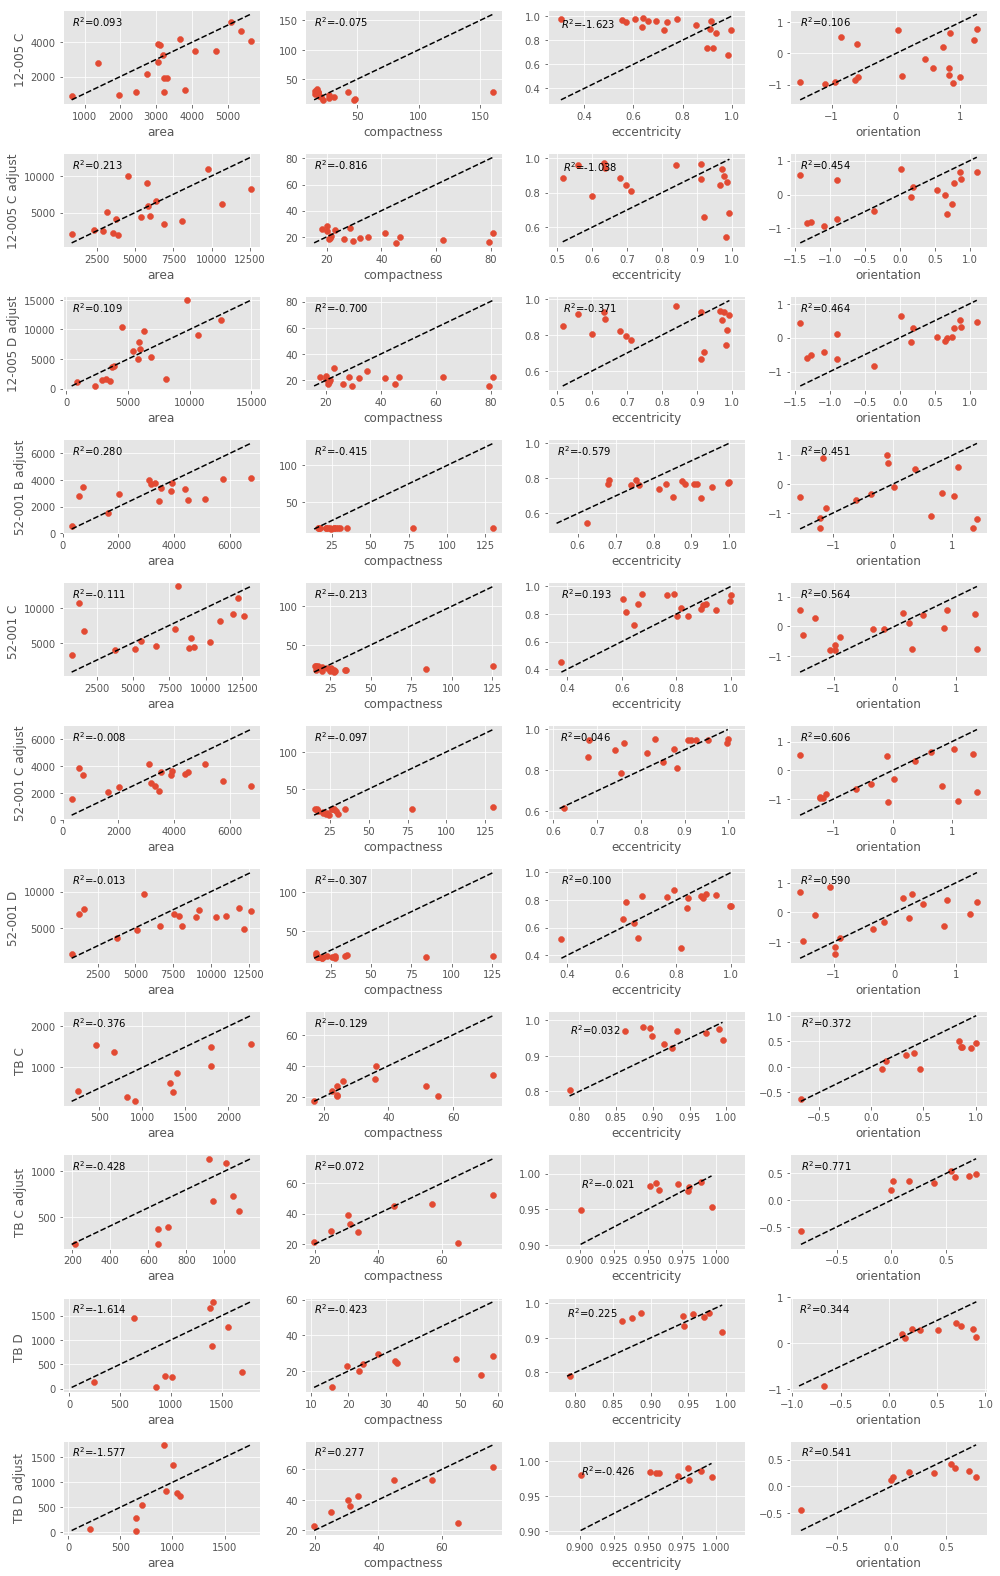

In [15]:
fig, axes = plt.subplots(ncols=len(columns), nrows=len(plot_files), figsize=(14, 2 * len(plot_files)))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    if isinstance(y, list):
        y = pd.concat(y)
        y_pred = pd.concat(y_pred)
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
fig.tight_layout()

In [16]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [17]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [18]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
           df         sum_sq        mean_sq        F    PR(>F)
y_hat     1.0  281054.068431  281054.068431  5.96114  0.044658
Residual  7.0  330033.931569   47147.704510      NaN       NaN

compactness
           df       sum_sq     mean_sq         F    PR(>F)
y_hat     1.0   929.999673  929.999673  3.100682  0.121647
Residual  7.0  2099.537089  299.933870       NaN       NaN

eccentricity
           df        sum_sq       mean_sq         F   PR(>F)
y_hat     1.0  2.668476e-08  2.668476e-08  0.000028  0.99589
Residual  7.0  6.556125e-03  9.365893e-04       NaN      NaN

orientation
           df    sum_sq   mean_sq          F    PR(>F)
y_hat     1.0  1.463659  1.463659  19.411667  0.003134
Residual  7.0  0.527807  0.075401        NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
